<a href="https://colab.research.google.com/github/JoaoVitorSesma/Predicao-da-Sobrevida-em-Pacientes-com-Cancer-Colorretal-IC/blob/main/Banco_de_Dados_(Lifelines).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# <font size="24" color=#EEDD82 face="Times New Roman"> * **✧** *</font><font size="24" color=#EEDD82 face="Times New Roman"> **COX** </font><font size="24" color=#EEDD82 face="Times New Roman">* **✧** *</font>



### <font color=#FFB90F>**Importações**


---

*   [Scikit-Survival](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.linear_model.CoxPHSurvivalAnalysis.html)

*   [Lifelines](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#cox-s-proportional-hazard-model)

*   [Seaborn](https://seaborn.pydata.org/)

---

<font color = "#00FF00"> Banco de Dados obtidos a partir da própria bilioteca do Scikit-Survival, usando como dataset base: [load_breast_cancer](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.datasets.load_breast_cancer.html#id4). Este dataset tem um tototal de </font> <font color = #FF69B4>198 amostras (pacientes)</font> <font color = "#00FF00"> e </font> </font> <font color = #FF6A6A> 82 recursos (variáveis).

In [ ]:
!pip install scikit-survival --quiet
!pip install lifelines --quiet
!pip install seaborn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 65.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 5.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Configura o scikit-learn para exibir os estimadores em formato de texto
set_config(display="text")

### <font color=#FFB90F>**Processamento dos Dados**

#### <font color = #63B8FF>**Explicação**

---

<font color=00BFFF00BFFF#00FF7F>No processamento de dados, o conjunto de dados de câncer de mama é carregado e são feitas as primeiras análises do banco de dados. Sobre o conjunto de dados, dividimos ele entre 2 variáveis, "X" e "y", onde representam respectivamente, as características dos pacientes e a outra contém informações de sobrevivência (tempo de sobrevivência e se o evento de interesse, como a morte, ocorreu).

---

*  <font color=#FF0000#DAA520>**OneHotEncoder:**</font> Transforma variáveis categóricas em variáveis binárias (0 ou 1).

* <font color=#FF0000#DAA520>**Xt['days'] e Xt['event']:**</font> Adiciona colunas ao DataFrame transformado para indicar o tempo de sobrevivência (days) e se o evento ocorreu (event), invertendo, para melhorar o banco de dados, os valores de event para que True indique morte e False indique censura (sobrevivência ou perda de acompanhamento).

---

#### <font color = 	#C0FF3E>**Código**

In [ ]:
X, y = load_breast_cancer() # Carrega o conjunto de dados de câncer de mama, retornando X (características) e y (dados de sobrevivência)
Xt = OneHotEncoder().fit_transform(X) # Transforma os dados categóricos em variáveis binárias
Xt.round(2).head() # Exibe as primeiras linhas do DataFrame

,X200726_at,X200965_s_at,X201068_s_at,X201091_s_at,X201288_at,X201368_at,X201663_s_at,X201664_at,X202239_at,X202240_at,...,X221816_s_at,X221882_s_at,X221916_at,X221928_at,age,er=positive,grade=intermediate,grade=poorly differentiated,grade=unkown,size
0,10.93,8.96,11.63,10.96,11.52,12.04,9.62,9.81,10.02,7.85,...,10.13,10.93,6.48,5.99,57.0,0.0,0.0,1.0,0.0,3.0
1,12.24,9.53,12.63,11.59,12.32,10.78,10.60,10.70,10.16,8.74,...,10.21,9.56,4.97,7.05,57.0,1.0,0.0,1.0,0.0,3.0
2,11.66,10.24,12.57,9.17,11.70,11.35,9.38,10.16,10.03,8.13,...,10.16,9.31,4.28,6.83,48.0,0.0,0.0,1.0,0.0,2.5
3,12.17,9.82,12.11,9.09,13.13,11.86,8.40,8.67,10.73,8.65,...,10.66,10.21,5.71,6.93,42.0,1.0,0.0,1.0,0.0,1.8
4,11.48,11.49,11.78,8.89,10.43,11.40,7.74,8.64,9.56,8.48,...,11.57,10.93,5.82,6.66,46.0,1.0,1.0,0.0,0.0,3.0


In [ ]:
# Exibe os nomes das colunas do DataFrame
print(Xt.columns)

Index(['X200726_at', 'X200965_s_at', 'X201068_s_at', 'X201091_s_at',
       'X201288_at', 'X201368_at', 'X201663_s_at', 'X201664_at', 'X202239_at',
       'X202240_at', 'X202418_at', 'X202687_s_at', 'X203306_s_at',
       'X203391_at', 'X204014_at', 'X204015_s_at', 'X204073_s_at',
       'X204218_at', 'X204540_at', 'X204631_at', 'X204740_at', 'X204768_s_at',
       'X204888_s_at', 'X205034_at', 'X205848_at', 'X206295_at',
       'X207118_s_at', 'X208180_s_at', 'X208683_at', 'X209500_x_at',
       'X209524_at', 'X209835_x_at', 'X209862_s_at', 'X210028_s_at',
       'X210314_x_at', 'X210593_at', 'X211040_x_at', 'X211382_s_at',
       'X211762_s_at', 'X211779_x_at', 'X212014_x_at', 'X212567_s_at',
       'X214806_at', 'X214915_at', 'X214919_s_at', 'X215510_at',
       'X215633_x_at', 'X216010_x_at', 'X216103_at', 'X216693_x_at',
       'X217019_at', 'X217102_at', 'X217404_s_at', 'X217471_at', 'X217767_at',
       'X217771_at', 'X217815_at', 'X218430_s_at', 'X218478_s_at',
       'X218533_

In [ ]:
# Exibe o número de colunas do DataFrame original
print(Xt.shape[1])

82


In [ ]:
# Variável y com um tupla contendo (event, days)
Xt['days'] = [tup[-1] for tup in y] # Adiciona ao DataFrame transformado uma coluna 'days' que contém o tempo de sobrevivência (dias)
Xt['event'] = [tup[0] for tup in y] # Adiciona uma coluna 'event' que indica se o evento (morte) ocorreu (1 para sim, 0 para não)

# Para melhorar o banco de dados
Xt['event'] = [not x for x in Xt['event']] # Inverte os valores da coluna 'event' (True -> False e vice-versa)

In [ ]:
# Exibe a contagem de valores únicos na coluna 'event'
Xt.event.value_counts()

,count
event,
True,147
False,51


In [ ]:
# Exibe o DataFrame final (Com event e days adicionado (82 variáveis + 2 novas (dias e evento)))
Xt

,X200726_at,X200965_s_at,X201068_s_at,X201091_s_at,X201288_at,X201368_at,X201663_s_at,X201664_at,X202239_at,X202240_at,...,X221916_at,X221928_at,age,er=positive,grade=intermediate,grade=poorly differentiated,grade=unkown,size,days,event
0,10.926361,8.962608,11.630078,10.964107,11.518305,12.038527,9.623518,9.814798,10.016732,7.847383,...,6.477749,5.991885,57.0,0.0,0.0,1.0,0.0,3.0,723.0,False
1,12.242090,9.531718,12.626106,11.594716,12.317659,10.776911,10.604577,10.704329,10.161838,8.744875,...,4.968050,7.051130,57.0,1.0,0.0,1.0,0.0,3.0,6591.0,True
2,11.661716,10.238680,12.572919,9.166088,11.698658,11.353333,9.384927,10.161654,10.032721,8.125487,...,4.283777,6.828986,48.0,0.0,0.0,1.0,0.0,2.5,524.0,False
3,12.174021,9.819279,12.109888,9.086937,13.132617,11.859394,8.400839,8.670721,10.727427,8.650810,...,5.713404,6.927251,42.0,1.0,0.0,1.0,0.0,1.8,6255.0,True
4,11.484011,11.489233,11.779285,8.887616,10.429663,11.401139,7.741092,8.642018,9.556686,8.478862,...,5.817265,6.655448,46.0,1.0,1.0,0.0,0.0,3.0,3822.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,12.018292,8.323876,11.955274,10.740020,11.150428,10.650873,8.787549,9.747182,10.176306,9.240307,...,6.889179,5.892040,39.0,0.0,0.0,1.0,0.0,2.2,5673.0,True
194,11.711415,10.428482,12.420877,11.145993,11.084685,11.169750,10.870530,11.128882,9.573702,9.287522,...,5.393927,6.421038,46.0,0.0,0.0,1.0,0.0,3.2,404.0,False
195,11.939616,9.615587,11.962812,10.463171,11.514539,11.487394,10.443569,11.104227,9.051649,7.279063,...,5.922925,6.979894,47.0,1.0,0.0,0.0,0.0,2.5,2225.0,True
196,11.848449,10.528911,11.318453,8.609631,13.719035,12.909814,7.525994,8.255546,9.788903,7.343499,...,7.278383,7.195797,43.0,1.0,1.0,0.0,0.0,1.2,2722.0,True


### <font color=#FFB90F>**FIT**

#### <font color = #63B8FF>**Explicação**

---

<font color=00BFFF00BFFF#00FF7F>Nesta parte, há o ajuste do modelo de Cox Proportional Hazards, que é usado para investigar o efeito de várias variáveis sobre o tempo até a ocorrência de um evento.

---

* <font color=#FF0000#DAA520>**CoxPHFitter():**</font> Cria um modelo de Cox ajustado para o modelo proporcional de hazard.

* <font color=#FF0000#DAA520>**fit():**</font> Ajusta o modelo aos dados, especificando as colunas que contêm o tempo de duração e o indicador de evento.

* <font color=#FF0000#DAA520>**print_summary():**</font> Exibe um sumário com os resultados do ajuste, incluindo coeficientes de regressão, valores p, intervalos de confiança, entre outros (documentação a baixo).

---

<font color=#FFB90F>**Parâmetros Principais:**

* <font color=#FF0000#DAA520>**DataFrame:**</font> Contem as covariáveis ou características dos indivíduos. Cada linha corresponde a um indivíduo (por exemplo, um paciente), e cada coluna corresponde a uma característica ou variável preditora.

* <font color=#FF0000#DAA520>**duration_col:**</font> Nome da coluna dentro de Xt que contém o tempo de duração ou tempo de seguimento para cada indivíduo. Este tempo representa o período até a ocorrência do evento de interesse ou até o último acompanhamento, se o evento não ocorreu (censura).

* <font color=#FF0000#DAA520>**event_col:**</font >Nome da coluna dentro de Xt que indica se o evento de interesse ocorreu (por exemplo, se o paciente morreu). É uma coluna binária onde 1 indica que o evento ocorreu e 0 indica que o indivíduo foi censurado (o evento não ocorreu até o fim do período de observação).

---

<font color=00BFFF00BFFF#00FF7F> O modelo de Cox é ajustado aos dados. Este modelo busca uma relação linear entre as covariáveis (logaritmo do risco relativo) e o logaritmo do tempo de falha (ou sobrevivência). O ajuste é realizado utilizando métodos numéricos, como a maximização da verossimilhança parcial, que considera a censura nos dados.

<font color=00BFFF00BFFF#00FF7F> O modelo também assume que o hazard ratio é uma função exponencial das covariáveis, e que o efeito dessas covariáveis é multiplicativo no tempo de risco.

---

<font color=#FFB90F>**OBS:**</font> Como o modelo de Cox assume que os hazards são proporcionais ao longo do tempo. A função fit() pode incluir verificações para garantir que essa suposição de proporcionalidade seja válida. Se a suposição for violada, ajustes ou modificações ao modelo podem ser necessários.

---

#### <font color=	#AB82FF>**Colunas**

#####<font color=#C0FF3E>**coef_(Coeficiente)**

---

* <font color=#FF0000#DAA520>**Significado Estatístico:**</font> Representa o coeficiente de regressão estimado para cada variável independente no modelo de Cox. Ele indica a direção e magnitude da associação entre a variável e o risco de falha (evento). Um coeficiente positivo sugere que o aumento na variável está associado a um aumento no risco do evento, enquanto um coeficiente negativo indica uma associação protetora (redução do risco).
* <font color=#FF0000#DAA520>**Significado Prático:**</font> Se uma variável como "idade" tem um coeficiente positivo, isso indicaria que pacientes mais velhos têm um risco maior de falhar (ex: morrer) em comparação com pacientes mais jovens.

---

#####<font color=#C0FF3E>**exp(coef)_(Hazard Ratio)**

---

* <font color=#FF0000#DAA520>**Significado Estatístico:**</font> É a exponenciação do coeficiente, conhecido como hazard ratio. Ele indica a razão dos riscos de falha entre dois grupos que diferem em uma unidade na variável preditora. Se exp(coef) for maior que 1, isso sugere um aumento no risco associado ao aumento da variável; se for menor que 1, sugere um efeito protetor.
* <font color=#FF0000#DAA520>**Significado Prático:**</font> Se exp(coef) for 1.5 para a variável "fumar", isso indica que indivíduos que fumam têm um risco 50% maior de falha (ex: morrer) em comparação com não fumantes.

---

#####<font color=#C0FF3E>**se(coef)_(Erro Padrão do Coeficiente)**

---

* <font color=#FF0000#DAA520>**Significado Estatístico:**</font> O erro padrão do coeficiente é uma medida da incerteza na estimativa do coeficiente. Ele é usado para calcular os intervalos de confiança e os valores p associados ao coeficiente.
* <font color=#FF0000#DAA520>**Significado Prático:**</font> Um alto erro padrão pode indicar que o coeficiente estimado é instável, ou que há variabilidade nos dados que dificulta a obtenção de uma estimativa precisa.

---

#####<font color=#C0FF3E>**[coef lower 95% e coef upper 95%]_(Intervalo de Confiança de 95% para o Coeficiente)**

---

* <font color=#FF0000#DAA520>**Significado Estatístico:**</font> Esses valores representam o intervalo de confiança para o coeficiente estimado no modelo.
Eles indicam a faixa na qual podemos ter 95% de certeza de que o verdadeiro valor do coeficiente se encontra.
* <font color=#FF0000#DAA520>**Significado Prático:**</font> Se o intervalo de confiança não incluir zero, isso sugere que o efeito da variável é estatisticamente significativo. Por exemplo, se o intervalo for [0.2, 0.5], podemos dizer com 95% de confiança que a variável aumenta o risco de falha (evento) com um coeficiente entre 0.2 e 0.5.

---

#####<font color=#C0FF3E>**[exp(coef) lower 95%, exp(coef) upper 95%]_(Intervalo de Confiança de 95% para o Hazard Ratio)**

---

* <font color=#FF0000#DAA520>**Significado Estatístico:**</font> Esses valores representam o intervalo dentro do qual podemos estar 95% confiantes de que o verdadeiro hazard ratio se encontra. O intervalo é baseado na distribuição normal dos coeficientes.
* <font color=#FF0000#DAA520>**Significado Prático:**</font> Um intervalo de confiança que não inclua 1 sugere que a associação entre a variável e o risco é estatisticamente significativa. Por exemplo, se o intervalo de confiança para "pressão arterial alta" for [1.2, 2.3], isso sugere que a pressão arterial alta aumenta significativamente o risco de falha.

---

#####<font color=#C0FF3E>**cmp to_(Comparação com Modelo de Referência):**

---

* <font color=#FF0000#DAA520>**Significado Estatístico:**</font> Este valor é usado para comparar o modelo atual com um modelo de referência, geralmente o modelo nulo (um modelo que não inclui variáveis explicativas). Ele ajuda a verificar se a inclusão das variáveis no modelo realmente melhora a predição.
* <font color=#FF0000#DAA520>**Significado Prático:**</font> Um valor que mostra uma melhora significativa em comparação ao modelo de referência indica que as variáveis do modelo atual são úteis para explicar a variação nos tempos de sobrevivência.

---

#####<font color=#C0FF3E>**z_(Estatística Z)**

---

* <font color=#FF0000#DAA520>**Significado Estatístico:**</font> A estatística Z é o coeficiente dividido pelo seu erro padrão. Ela é usada para testar a hipótese nula de que o coeficiente é igual a zero (ou seja, que a variável não tem efeito sobre o risco de falha).
* <font color=#FF0000#DAA520>**Significado Prático:**</font> Valores absolutos de Z maiores indicam que é menos provável que a associação observada seja devida ao acaso. Por exemplo, uma estatística Z muito alta sugere uma forte evidência contra a hipótese nula.

---

#####<font color=#C0FF3E>**p_(Valor p)**

---

* <font color=#FF0000#DAA520>**Significado Estatístico:**</font> O valor p indica a probabilidade de observar um valor da estatística Z tão extremo quanto o observado, assumindo que a hipótese nula é verdadeira. Um valor p baixo (tipicamente < 0.05) sugere que o efeito da variável é estatisticamente significativo.
* <font color=#FF0000#DAA520>**Significado Prático:**</font> Se o valor p associado a uma variável como "tratamento" for menor que 0.05, isso sugere que há evidência suficiente para afirmar que o tratamento tem um efeito significativo sobre o tempo de sobrevivência.

---

#####<font color=#C0FF3E>**log2(p)_(Transformação do Valor p):**

---

* <font color=#FF0000#DAA520>**Significado Estatístico:**</font> Esta é uma transformação do valor p, onde um valor mais alto de -log2(p) indica um valor p menor, sugerindo maior significância estatística. É usado para destacar a força da evidência contra a hipótese nula.
* <font color=#FF0000#DAA520>**Significado Prático:**</font> Valores altos de -log2(p) (como 10 ou mais) indicam que a associação observada é muito improvável de ser devida ao acaso, tornando a variável altamente significativa no modelo.

---

#### <font color=#FF34B3>**Métricas**

#####<font color=#00FF7F>**Concordance_(C-Index)**

---

* <font color=#FF0000#DAA520>**Significado Estatístico:**</font> O índice de concordância (ou C-index) mede a capacidade do modelo em classificar corretamente os tempos de sobrevivência. Em outras palavras, ele avalia se, para dois pacientes quaisquer, o modelo prediz corretamente qual deles terá um tempo de sobrevivência maior. O valor do índice de concordância varia de 0.5 (não melhor que o acaso) a 1.0 (perfeita discriminação).
* <font color=#FF0000#DAA520>**Significado Prático:**</font> Imagine que você tem dois pacientes, A e B, e sabe que o paciente A sobreviveu por mais tempo que o paciente B. Se o modelo previu corretamente que A tinha um risco menor que B (ou seja, A deveria viver mais), isso contribui positivamente para o C-index. Se o modelo errou, a concordância diminui.

---

#####<font color=#00FF7F>**Partial AIC_(Critério de Informação de Akaike Parcial)**

---

* <font color=#FF0000#DAA520>**Significado Estatístico:**</font> O AIC é uma medida usada para comparar modelos estatísticos, penalizando pela complexidade do modelo (número de parâmetros) e ajustando para o ajuste aos dados. Um valor menor de AIC indica um modelo que, comparativamente, é mais eficiente em balancear a qualidade do ajuste e a simplicidade. O "Partial AIC" refere-se à aplicação dessa medida especificamente para o modelo de Cox, considerando a parte dos dados usados.
* <font color=#FF0000#DAA520>**Significado Prático:**</font>  Se você está comparando dois modelos de Cox diferentes para prever a sobrevivência de pacientes, o modelo com o menor Partial AIC seria preferido, pois sugere que ele tem um bom ajuste aos dados sem ser excessivamente complexo.

---

#####<font color=#00FF7F>**Log-Likelihood Ratio Test_(Teste de Razão de Verossimilhança)**

---

* <font color=#FF0000#DAA520>**Significado Estatístico:**</font> Este teste compara a verossimilhança (um valor que indica o quão bem um modelo ajusta os dados) de dois modelos: um modelo mais simples (modelo nulo, sem variáveis explicativas) e um modelo mais complexo (o modelo ajustado). O teste calcula a diferença (razão) entre as log-verossimilhanças desses dois modelos. Se essa diferença for significativa, sugere-se que o modelo ajustado com variáveis explicativas oferece um ajuste significativamente melhor aos dados do que o modelo nulo.
* <font color=#FF0000#DAA520>**Significado Prático:**</font> Suponha que você tem um modelo de Cox sem nenhuma variável explicativa (modelo nulo) e outro com variáveis como idade e tratamento. Se o teste de razão de verossimilhança indicar uma diferença significativa, isso sugere que incluir idade e tratamento realmente melhora a capacidade do modelo de prever a sobrevivência.

---

#####<font color=#00FF7F>**Log2(p) of LL-Ratio Test_(Logaritmo Base 2 do p-Valor do Teste de Razão de Verossimilhança)**

---

* <font color=#FF0000#DAA520>**Significado Estatístico:**</font> Este valor é a transformação logarítmica do p-value obtido no teste de razão de verossimilhança. O p-value indica a probabilidade de observar os dados sob a hipótese nula (de que as variáveis explicativas não têm efeito). A transformação log2 é usada para facilitar a interpretação, especialmente em comparações.
* <font color=#FF0000#DAA520>**Significado Prático:**</font> Se o log2(p) for um valor muito negativo, isso sugere um p-value muito pequeno, indicando que as variáveis no modelo são estatisticamente significativas na explicação da variação nos tempos de sobrevivência. Isso reforça a confiança na utilidade do modelo ajustado.

---

#### <font color = #C0FF3E>**Código**

In [ ]:
from lifelines import CoxPHFitter

cph = CoxPHFitter() # Cria uma instância do modelo de Cox Proportional Hazards
cph.fit(Xt, duration_col='days', event_col='event') # Ajusta o modelo aos dados, das colunas de duração e evento
# cph.fit(rossi, duration_col='week', event_col='arrest', formula="fin + wexp + age * prio") #Exemplo com fórmula

cph.print_summary() # Exibe um sumário detalhado do modelo ajustado

<lifelines.CoxPHFitter: fitted with 198 total observations, 51 right-censored observations>
             duration col = 'days'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 198
number of events observed = 147
   partial log-likelihood = -532.66
         time fit was run = 2024-09-12 15:23:39 UTC

---
                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                           
X200726_at                   -0.40       0.67       0.57            -1.51             0.72                 0.22                 2.05
X200965_s_at                  0.14       1.15       0.24            -0.34             0.61                 0.71                 1.84
X201068_s_at                  0.92       2.51       0.56            -0.17             2.01                 0.84                 7.48
X201091_s_at                 -0.45       0.64       0.41            -1.26             0.36                 0.28                 1.43
X201288_at                    0.36       1.43       0.34            -0.31             1.03                 0.73                 2.79
X201368_at                   -0.33       0.72       0.34            -0.99             0.33                 0.37                 1.40
X201663_s_at                 -0.76       0.47       0.48            -1.70             0.18                 0.18                 1.19
X201664_at                    1.22       3.38       0.51             0.22             2.22                 1.24                 9.18
X202239_at                   -0.20       0.82       0.32            -0.83             0.44                 0.44                 1.55
X202240_at                   -0.03       0.97       0.23            -0.47             0.41                 0.63                 1.51
X202418_at                    0.34       1.41       0.55            -0.73             1.42                 0.48                 4.12
X202687_s_at                 -0.12       0.88       0.23            -0.57             0.32                 0.57                 1.38
X203306_s_at                  1.05       2.85       0.40             0.27             1.83                 1.31                 6.21
X203391_at                    1.02       2.78       0.32             0.39             1.65                 1.48                 5.22
X204014_at                   -0.29       0.75       0.23            -0.74             0.17                 0.48                 1.18
X204015_s_at                  0.19       1.21       0.30            -0.39             0.78                 0.68                 2.17
X204073_s_at                 -0.26       0.77       0.15            -0.54             0.03                 0.58                 1.03
X204218_at                   -0.42       0.66       0.36            -1.13             0.29                 0.32                 1.34
X204540_at                   -0.23       0.80       0.09            -0.41            -0.04                 0.66                 0.96
X204631_at                    0.24       1.28       0.14            -0.04             0.52                 0.96                 1.69
X204740_at                    0.20       1.22       0.26            -0.32             0.71                 0.73                 2.04
X204768_s_at                 -0.08       0.92       0.37            -0.80             0.64                 0.45                 1.90
X204888_s_at                  0.15       1.16       0.17            -0.19             0.48                 0.83                 1.62
X205034_at                   -0.62       0.54       0.22            -1.06            -0.18                 0.35                 0.84
X205848_at                    0.14       1.16       0.09            -0.03             0.32                 0.97                 1.38
X206295_at                   -0.09       0.91       0

### <font color=#FFB90F>**C-índex**

#### <font color = #63B8FF>**Explicação**

---

<font color=00BFFF00BFFF#00FF7F>O índice de concordância mede a habilidade do modelo em prever corretamente a ordem dos tempos de sobrevivência. Um valor próximo de 1 indica boa concordância entre predições e observações. Por outro lado, se o modelo tem como valor proximo a 0,5, isto indica má concordância entre predições e observações.

---

<font color=#FFB90F>**Parâmetros Principais:**

* <font color=#FF0000#DAA520>**Xt:**</font> Este é o DataFrame que contém as variáveis independentes (covariáveis). Ele deve ser o mesmo DataFrame que foi usado para ajustar o modelo (cph.fit). O DataFrame Xt contém as características dos pacientes que o modelo usará para prever os tempos de sobrevivência.

* <font color=#FF0000#DAA520>**scoring_method:**</font> Quando definido como 'concordance_index', ele instrui a função a calcular o C-index específico para o modelo de sobrevivência ajustado.

---

<font color=#FFB90F>**Processo Interno de Cálculo:**

 De começo, o modelo de Cox ajustado atribui um risco a cada paciente, baseado nas características dele (as variáveis em Xt). Sendo assim, pacientes com maior risco previsto têm maior chance de ter o evento (por exemplo, falecer) mais cedo.

O cálculo do C-index envolve pegar todos os pares possíveis de pacientes no seu conjunto de dados. E para cada par, o modelo faz duas coisas:
- Primeiro, verifica qual paciente realmente sobreviveu por mais tempo observando os dados reais
- Segundo, olha para as prediçõe e verifica se o modelo previu corretamente qual paciente tinha um risco menor (e, portanto, deveria sobreviver mais tempo).

Se o modelo acertar que o paciente A (que sobreviveu mais tempo) tinha um risco menor do que o paciente B, isso é chamado de "concordância". Porém,
se o modelo errar e prever que o paciente B (que teve um tempo de sobrevivência mais curto) deveria ter sobrevivido mais que o paciente A, isso é uma "discordância".

Sendo assim, o C-index é basicamente a proporção de pares onde o modelo acertou (ou seja, houve concordância) em relação ao total de pares comparáveis.

#### <font color = #C0FF3E>**Código**


In [ ]:
# Calcula o índice de concordância (concordance index) do modelo ajustado
concordance_index = cph.score(Xt, scoring_method='concordance_index')
print(f'Concordance Index: {concordance_index}')

Concordance Index: 0.7637101649537956


### <font color=#FFB90F>**Penalização**

---

<font color =00BFFF00BFFF#00FF7F>Não usada no momento, essa seção sugere a possibilidade de aplicar penalização ao modelo de Cox. Penalizações (como Lasso ou Ridge) são usadas para reduzir o overfitting e selecionar variáveis para ajustar modelos com um grande número de preditores.

---

In [ ]:
# #penalty = np.array([0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]) #penalização

# cph = CoxPHFitter(penalizer=penalty)
# cph.fit(Xt, duration_col='days', event_col='event')
# cph.print_summary()

### <font color=#FFB90F>**P-Values**


#### <font color = #63B8FF>**Explicação**

---

<font color=00BFFF00BFFF#00FF7F> Para encontarmos a variáveis mais significativas para o modelo de predição, selecionamos as variáveis independentes que têm p-value < 0.05, indicando significância estatística no modelo de Cox.

---

* <font color=#FF0000#DAA520>**Xt_significativos:**</font> Cria um DataFrame com apenas as variáveis significativas, além das colunas days e event para reanálise.

---

#### <font color = #C0FF3E>**Código**

##### <font color=#AB82FF>**Valores significativos (Modelo Simplificado)**

In [ ]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
X200726_at,-0.396533,0.672648,0.567712,-1.509228,0.716162,0.221081,2.046564,0.0,-0.698475,0.484880,1.044300
X200965_s_at,0.137424,1.147315,0.242281,-0.337439,0.612287,0.713596,1.844646,0.0,0.567210,0.570572,0.809520
X201068_s_at,0.921590,2.513284,0.556166,-0.168476,2.011656,0.844952,7.475689,0.0,1.657041,0.097511,3.358289
X201091_s_at,-0.448344,0.638685,0.412307,-1.256451,0.359763,0.284663,1.432990,0.0,-1.087403,0.276859,1.852779
X201288_at,0.356406,1.428188,0.341322,-0.312573,1.025386,0.731562,2.788172,0.0,1.044193,0.296396,1.754401
...,...,...,...,...,...,...,...,...,...,...,...
er=positive,-0.054264,0.947182,0.440201,-0.917043,0.808514,0.399699,2.244570,0.0,-0.123272,0.901892,0.148974
grade=intermediate,-0.879830,0.414853,0.361940,-1.589219,-0.170441,0.204085,0.843293,0.0,-2.430874,0.015062,6.052901
grade=poorly differentiated,-0.219757,0.802714,0.511384,-1.222052,0.782538,0.294625,2.187016,0.0,-0.429730,0.667392,0.583393


In [ ]:
cph.summary['p']

,p
covariate,
X200726_at,0.484880
X200965_s_at,0.570572
X201068_s_at,0.097511
X201091_s_at,0.276859
X201288_at,0.296396
...,...
er=positive,0.901892
grade=intermediate,0.015062
grade=poorly differentiated,0.667392


In [ ]:
cph.summary[cph.summary['p'] < 0.05].index , len(cph.summary[cph.summary['p'] < 0.05].index)

(Index(['X201664_at', 'X203306_s_at', 'X203391_at', 'X204540_at', 'X205034_at',
        'X210028_s_at', 'X211040_x_at', 'X211779_x_at', 'X216693_x_at',
        'X217404_s_at', 'X218782_s_at', 'X218883_s_at', 'age',
        'grade=intermediate'],
       dtype='object', name='covariate'),
 14)

In [ ]:
Xt_significativos = Xt[ cph.summary[cph.summary['p'] < 0.05].index ]

Xt_significativos = pd.concat([Xt_significativos, Xt[['days','event']]], axis=1)
Xt_significativos

,X201664_at,X203306_s_at,X203391_at,X204540_at,X205034_at,X210028_s_at,X211040_x_at,X211779_x_at,X216693_x_at,X217404_s_at,X218782_s_at,X218883_s_at,age,grade=intermediate,days,event
0,9.814798,9.640372,10.736998,9.905932,8.060232,8.727915,9.871713,9.987269,8.421447,5.245020,9.012149,11.098567,57.0,0.0,723.0,False
1,10.704329,10.212158,10.634080,9.343768,9.964649,9.132981,9.720058,9.178235,9.760751,3.397536,10.631153,10.424387,57.0,0.0,6591.0,True
2,10.161654,9.353904,10.053435,6.924000,9.017518,9.007883,11.124228,10.121054,9.341145,10.424956,8.779378,10.240787,48.0,0.0,524.0,False
3,8.670721,9.818331,10.538440,7.198628,8.455318,8.539764,9.641587,10.012768,9.484365,2.565533,8.340574,9.458572,42.0,0.0,6255.0,True
4,8.642018,9.723174,10.830014,12.999917,6.539634,7.830245,10.682795,10.729222,10.909458,3.427746,7.367397,8.993181,46.0,1.0,3822.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,9.747182,10.839615,10.534575,2.516564,9.843617,10.232017,10.564294,9.464865,9.780507,6.008893,8.720698,10.213986,39.0,0.0,5673.0,True
194,11.128882,9.308772,9.633750,9.257450,9.326457,10.828823,10.208667,9.723909,10.140307,2.818200,10.785981,10.995291,46.0,0.0,404.0,False
195,11.104227,9.803908,10.969469,9.770737,7.994452,9.229651,9.847672,10.499166,9.980880,6.920305,9.123865,9.906806,47.0,0.0,2225.0,True
196,8.255546,9.177714,11.255075,6.639936,5.652260,8.293609,9.697427,10.776787,8.432205,3.701951,9.634984,8.428090,43.0,1.0,2722.0,True


In [ ]:
from lifelines import CoxPHFitter

cph = CoxPHFitter() # Cria uma instância do modelo de Cox Proportional Hazards
cph.fit(Xt_significativos, duration_col='days', event_col='event') # Ajusta o modelo aos dados, das colunas de duração e evento
# cph.fit(rossi, duration_col='week', event_col='arrest', formula="fin + wexp + age * prio") #Exemplo com fórmula

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 198 total observations, 51 right-censored observations>
             duration col = 'days'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 198
number of events observed = 147
   partial log-likelihood = -577.35
         time fit was run = 2024-09-12 15:23:40 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
X201664_at           0.19       1.21       0.15            -0.10             0.49                 0.90                 1.63
X203306_s_at         0.59       1.81       0.17             0.25             0.93                 1.29                 2.55
X203391_at           0.34       1.41       0.16             0.02             0.67                 1.02                 1.95
X204540_at          -0.03       0.97       0.05            -0.13             0.07                 0.88                 1.07
X205034_at          -0.50       0.60       0.11            -0.71            -0.30                 0.49                 0.74
X210028_s_at        -0.29       0.75       0.16            -0.60             0.02                 0.55                 1.02
X211040_x_at        -0.12       0.89       0.15            -0.41             0.17                 0.66                 1.18
X211779_x_at         0.48       1.61       0.26            -0.03             0.99                 0.97                 2.68
X216693_x_at        -0.03       0.97       0.11            -0.23             0.18                 0.79                 1.20
X217404_s_at         0.05       1.05       0.04            -0.04             0.13                 0.97                 1.14
X218782_s_at         0.27       1.31       0.10             0.08             0.46                 1.08                 1.59
X218883_s_at         0.30       1.35       0.14             0.02             0.58                 1.02                 1.79
age                  0.02       1.02       0.01            -0.00             0.05                 1.00                 1.05
grade=intermediate  -0.49       0.61       0.20            -0.88            -0.10                 0.42                 0.90

                     cmp to     z      p   -log2(p)
covariate                                          
X201664_at             0.00  1.27   0.20       2.30
X203306_s_at           0.00  3.41 <0.005      10.58
X203391_at             0.00  2.09   0.04       4.77
X204540_at             0.00 -0.61   0.54       0.89
X205034_at             0.00 -4.74 <0.005      18.83
X210028_s_at           0.00 -1.85   0.06       3.95
X211040_x_at           0.00 -0.83   0.41       1.30
X211779_x_at           0.00  1.83   0.07       3.90
X216693_x_at           0.00 -0.25   0.80       0.32
X217404_s_at           0.00  1.11   0.27       1.90
X218782_s_at           0.00  2.75   0.01       7.40
X218883_s_at           0.00  2.07   0.04       4.70
age                    0.00  1.80   0.07       3.80
grade=intermediate     0.00 -2.47   0.01       6.21
---
Concordance = 0.65
Partial AIC = 1182.69
log-likelihood ratio test = 47.59 on 14 df
-log2(p) of ll-ratio test = 15.99

##### <font color=#FF34B3>**Valores significativos (Modelo Completo)**

---

<font color=00BFFF00BFFF#00FF7F>Filtra variáveis baseadas no valor p e retorna um DataFrame com as variáveis significativas.

---

<font color=#EEDD82>**Parâmetros:**
* <font color=#FF0000#DAA520>**cph_summary:**</font> DataFrame de sumário do modelo de Cox contendo coeficientes e valores p.
* <font color=#FF0000#DAA520>**Xt:**</font> DataFrame com as variáveis independentes e dados de sobrevivência.
* <font color=#FF0000#DAA520>**p_val_threshold:**</font> Limite de corte para considerar uma variável significativa (p < threshold).

---

<font color=#EEDD82>**Retorna:**
* <font color=#FF0000#DAA520>**Xt_significativos:**</font> DataFrame contendo apenas as variáveis significativas e colunas 'days' e 'event'.

---

In [ ]:
# Função para escolher as variáveis significativas (p_value<0.05)
def ajuste_modelo_significativo(cph_summary, Xt, p_val_threshold=0.05):
    # Cria uma cópia da variável Xt original para preservar a original
    Xt_copia = Xt.copy()

    # Seleciona os índices das variáveis que possuem p-value abaixo do threshold
    indices_significativos = cph_summary[cph_summary['p'] < p_val_threshold].index

    # Filtra a cópia da Xt para incluir apenas as variáveis significativas
    Xt_significativos = Xt_copia[indices_significativos]

    # Adiciona as colunas 'days' e 'event' à cópia filtrada
    Xt_significativos = pd.concat([Xt_significativos, Xt_copia[['days', 'event']]], axis=1)

    return Xt_significativos

# Exibição do Resultado das variáveis
Xt_significativos = ajuste_modelo_significativo(cph.summary, Xt)
cph.fit(Xt_significativos, duration_col='days', event_col='event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 198 total observations, 51 right-censored observations>
             duration col = 'days'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 198
number of events observed = 147
   partial log-likelihood = -583.08
         time fit was run = 2024-09-12 15:23:40 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
X203306_s_at         0.47       1.60       0.16             0.16             0.78                 1.17                 2.18
X203391_at           0.33       1.39       0.15             0.04             0.62                 1.04                 1.85
X205034_at          -0.51       0.60       0.10            -0.70            -0.32                 0.50                 0.73
X218782_s_at         0.28       1.33       0.09             0.11             0.46                 1.11                 1.58
X218883_s_at         0.19       1.21       0.12            -0.05             0.43                 0.95                 1.53
grade=intermediate  -0.48       0.62       0.18            -0.84            -0.12                 0.43                 0.89

                     cmp to     z      p   -log2(p)
covariate                                          
X203306_s_at           0.00  2.97 <0.005       8.38
X203391_at             0.00  2.22   0.03       5.26
X205034_at             0.00 -5.20 <0.005      22.23
X218782_s_at           0.00  3.17 <0.005       9.34
X218883_s_at           0.00  1.58   0.11       3.12
grade=intermediate     0.00 -2.61   0.01       6.80
---
Concordance = 0.63
Partial AIC = 1178.15
log-likelihood ratio test = 36.13 on 6 df
-log2(p) of ll-ratio test = 18.55

In [ ]:
from lifelines import CoxPHFitter

'''Comparação dos Modelos'''

# Modelo original:
# Ajuste do modelo original
cph_original = CoxPHFitter()
cph_original.fit(Xt, duration_col='days', event_col='event')

# Calcula o C-index para o modelo original
c_index_original = cph_original.score(Xt, scoring_method='concordance_index')
print(f'C-index para o modelo original: {c_index_original}')



# Variáveis significativas:
# Ajuste do modelo com variáveis significativas
cph_significativo = CoxPHFitter()
cph_significativo.fit(Xt_significativos, duration_col='days', event_col='event')

# Calcula o C-index para o modelo com variáveis significativas
c_index_significativo = cph_significativo.score(Xt_significativos, scoring_method='concordance_index')
print(f'C-index para o modelo com variáveis significativas: {c_index_significativo}')

C-index para o modelo original: 0.7637101649537956
C-index para o modelo com variáveis significativas: 0.6327834873477848


### <font color=#FFB90F>**Métricas do R²**



---

<font color=00BFFF00BFFF#00FF7F> Nesta seção, avaliamos a precisão e a performace do modelo de regressão de Cox utilizando diversas métricas estatísticas. Estas métricas calculadas avaliam a acurácia das previsões feitas pelo modelo.

---

#### <font color=#AB82FF>**Métricas**

##### <font color=#7FFFD4>**Erro Percentual Absoluto Médio (MAPE)**

---

* <font color=#FF0000#DAA520>**Significado:**</font> Mede a precisão das previsões ao calcular a média dos erros percentuais absolutos entre os valores reais e previstos. É uma métrica útil para entender a precisão do modelo em termos relativos.
* <font color=#FF0000#DAA520>**Interpretação Prática:**</font> Um MAPE mais baixo indica que as previsões do modelo estão mais próximas dos valores reais em termos percentuais.

---

##### <font color=#7FFFD4>**Erro Quadrático Médio (MSE)**

---

* <font color=#FF0000#DAA520>**Significado:**</font> Mede a média dos quadrados dos erros (diferença entre valores reais e previstos). O MSE é sensível a outliers, o que significa que grandes erros terão um impacto maior nessa métrica.
* <font color=#FF0000#DAA520>**Interpretação Prática:**</font> Um MSE mais baixo indica uma menor diferença média entre os valores previstos e os valores reais.

---

##### <font color=#7FFFD4>**Erro Médio Absoluto (MAE)**

---

* <font color=#FF0000#DAA520>**Significado:**</font> Mede a média dos erros absolutos entre os valores reais e previstos, fornecendo uma noção de quanto, em média, as previsões do modelo diferem dos valores observados.
* <font color=#FF0000#DAA520>**Interpretação Prática:**</font> Um MAE mais baixo sugere que, em média, as previsões do modelo estão mais próximas dos valores reais.

---

##### <font color=#7FFFD4>**Raiz do Erro Quadrático Médio (RMSE)**

---

* <font color=#FF0000#DAA520>**Significado:**</font> É a raiz quadrada do MSE e fornece uma medida de erro na mesma unidade dos valores observados, facilitando a interpretação.
* <font color=#FF0000#DAA520>**Interpretação Prática:**</font> Assim como o MSE, um RMSE mais baixo indica previsões mais precisas, com menos erro médio entre os valores previstos e observados.

---

#### <font color = #C0FF3E>**Código**

In [ ]:
# R² (backlog verificar como obter)

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score

def calcular_metricas(y_real, y_pred):
    mse = mean_squared_error(y_real, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_real, y_pred)
    mape = mean_absolute_percentage_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)

    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R²': r2}

In [ ]:
# from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

# def calcular_metricas(y_real, y_pred):
#     mse = mean_squared_error(y_real, y_pred)
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(y_real, y_pred)
#     mape = mean_absolute_percentage_error(y_real, y_pred)


#     return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}



# Calculando as métricas para o modelo original
y_pred_original = cph_original.predict_expectation(Xt)
metricas_original = calcular_metricas(Xt['days'], y_pred_original)

# Calculando as métricas para o modelo com variáveis significativas
y_pred_significativo = cph_significativo.predict_expectation(Xt_significativos)
metricas_significativo = calcular_metricas(Xt_significativos['days'], y_pred_significativo)



# Criando um DataFrame para comparar as métricas
df_comparacao = pd.DataFrame({
    'Métricas': ['MSE', 'RMSE', 'MAE', 'MAPE', 'R²'],
    'Modelo Original': [metricas_original['MSE'], metricas_original['RMSE'], metricas_original['MAE'], metricas_original['MAPE'], metricas_original['R²']],
    'Modelo Significativo': [metricas_significativo['MSE'], metricas_significativo['RMSE'], metricas_significativo['MAE'], metricas_significativo['MAPE'], metricas_significativo['R²'] ]
})

# Exibindo a tabela comparativa
display(df_comparacao)

,Métricas,Modelo Original,Modelo Significativo
0,MSE,5.037744e+06,4.655771e+06
1,RMSE,2.244492e+03,2.157724e+03
2,MAE,1.541900e+03,1.647020e+03
3,MAPE,1.466005e+00,1.498485e+00
4,R²,-3.228828e-01,-2.225791e-01


### <font color=#FFB90F>**Especificidade e Sensibilidade**

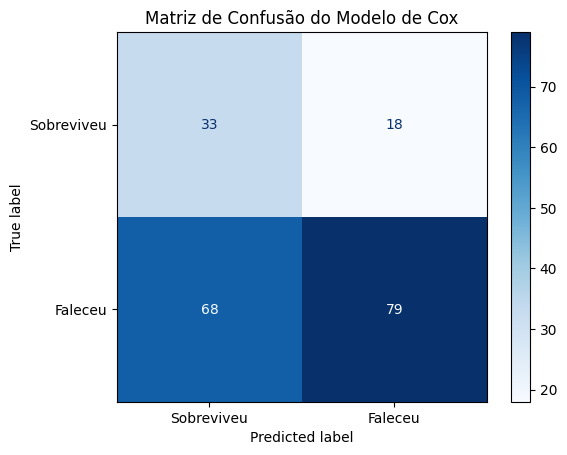

Sensibilidade (Recall): 0.54
Especificidade: 0.65


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Defina um threshold (ponto de corte) para classificar os pacientes em alto risco ou baixo risco
threshold = 1.0  # Ajuste o threshold conforme necessário

# Prever a função de risco parcial (hazard) usando o modelo Cox ajustado
predicted_risk = cph.predict_partial_hazard(Xt)

# Criar uma coluna de previsão de risco baseado no threshold
predicted_event = predicted_risk >= threshold

# Extraindo o valor real dos eventos (0 ou 1, onde 1 indica que o evento ocorreu, e 0 que não ocorreu)
real_event = Xt['event']

# Criar a matriz de confusão
cm = confusion_matrix(real_event, predicted_event)

# Exibir a matriz de confusão usando ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sobreviveu', 'Faleceu'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão do Modelo de Cox')
plt.show()

# Extrair Verdadeiros Negativos (TN), Falsos Positivos (FP), Falsos Negativos (FN) e Verdadeiros Positivos (TP)
tn, fp, fn, tp = cm.ravel()

# Calcular Sensibilidade e Especificidade
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f'Sensibilidade (Recall): {sensitivity:.2f}')
print(f'Especificidade: {specificity:.2f}')


### <font color=#FFB90F>**Survival Prediction**

#### <font color = #63B8FF>**Explicação**

---

<font color=00BFFF00BFFF#00FF7F>Aqui, foi realizada as previsões de sobrevivência com base no banco de dados inicial e ajustado. E seguida é feita a comparação do tempo real de sobrevida com os tempos estimados. Por fim, são feitas diversas comparações usando gráficos e análises específicas dos pacientes, para ajudar o entendimento dos resultados.

---

<font color=#FFB90F>**predict_survival_function():**

<font color=00BFFF00BFFF#00FF7F> É utilizada para prever a função de sobrevivência para um conjunto de dados fornecido. A função de sobrevivência descreve a probabilidade de um indivíduo sobreviver além de um determinado tempo $𝑡$.

<center><font size="5" color=#EEDD82>$𝑆(𝑡) = 𝑃(𝑇 > 𝑡)$</center><font>

* <font color=#FF0000#DAA520>**$𝑆(𝑡)$**</font> = Probabilidade de um indivíduo sobreviver além de um tempo específico $𝑡$;

* <font color=#FF0000#DAA520>**$𝑇$**</font> = Tempo de sobrevivência até o evento de interesse.

<font color=00BFFF00BFFF#00FF7F> Após ajustada para um conjunto de dados, é possível se calcular a função de sobrevivência esperada para cada indivíduo no conjunto de dados de entrada, com base nos parâmetros estimados do modelo ajustado. O ajuste envolve estimar os coeficientes de risco proporcional $(𝛽)$ que maximizam a verossimilhança dos dados de treinamento.

<center><font size="5" color=#EEDD82>$$h(t|x_i) = h_0(t).e^{x_i \beta}$$</center><font>

* <font color=#FF0000#DAA520>**$h(t|x_i)$**</font> = Função de risco para o tempo t dada as covariáveis para um indivíduo;

* <font color=#FF0000#DAA520>**$h_0(t)$**</font> = Função de risco base (Hazard baseline) sendo comum para todos os indivíduos;

* <font color=#FF0000#DAA520>**$𝑥_𝑖$**</font> = Covariáveis para um indivíduo;

* <font color=#FF0000#DAA520>**$𝛽$**</font> = Coeficientes de risco proporcional.

<center><font size="5" color="#EEDD82">$$H(t) = \int_0^t h(u) \, du$$</font></center>

* <font color=#FF0000#DAA520>**$𝐻(𝑡)$**</font> = Integral do hazard ratio ao longo do tempo até $𝑡$.

<center><font size="5" color="#EEDD82">$$S(t|x_i) = e^{-H(t|x_i)}$$</font></center>

* <font color=#FF0000#DAA520>**$S(t|x_i)$**</font> = Função de sobrevivência calculada usando a função de risco acumulado $𝐻(𝑡)$.

<font color=00BFFF00BFFF#00FF7F> Por fim, $H(t|x_i)$ é calculado como:

<center><font size="5" color="#EEDD82">$$H(t|x_i) = H_0(t).e^{x_i \beta}$$</font></center>

* <font color=#FF0000#DAA520>**$H(t|x_i)$**</font> = Função de risco acumulado para o modelo de sobrevivência;

* <font color=#FF0000#DAA520>**$H_0(t)$**</font> = Função de risco acumulado baseline.

---

<font color=#FFB90F>**predict_expectation():**

<font color=00BFFF00BFFF#00FF7F>Função que prevê o tempo de sobrevivência médio (ou "expectativa de sobrevivência"). Em outras palavras, para cada observação (indivíduo ou paciente), ela retorna o tempo médio estimado até a ocorrência do evento de interesse (por exemplo, morte).

<center><font size="5" color="#EEDD82">$$S(t|X_i) = e^{-H(t|X_i)}$$</font></center>

* <font color=#FF0000#DAA520>**$S(t|X_i)$**</font> = Função de sobrevivência para um indivíduo 𝑖;

* <font color=#FF0000#DAA520>**$H(t|X_i)$**</font> = Função de risco cumulativa para um indivíduo 𝑖.


<font color=00BFFF00BFFF#00FF7F>Após ajustada para um conjunto de dados, é possível se calcular a função de sobrevivência esperada para cada indivíduo no conjunto de dados de entrada, com base nos parâmetros estimados do modelo ajustado. O ajuste envolve estimar os coeficientes de risco proporcional (β)  que maximizam a verossimilhança dos dados de treinamento.

<center><font size="5" color="#EEDD82">$$h(t|X) = h_0(t) e^{\beta^T X}$$</font></center>

* <font color=#FF0000#DAA520>**$h(t|X)$**</font> = Função de risco (hazard function) para o tempo t dado o vetor de covariáveis X;

* <font color=#FF0000#DAA520>**$h_0(t)$**</font> = Função de risco base (baseline hazard) sendo comum para todos os indivíduos;

* <font color=#FF0000#DAA520>**$X$**</font> = Covariáveis;

* <font color=#FF0000#DAA520>**$𝛽$**</font> = Coeficientes de risco proporcional.

---

<font color=#FFB90F>**Diferenças:**

* <font color=#FF0000#DAA520>**predict_survival_function()**</font>

  * Retorna uma função completa de sobrevivência para cada indivíduo, mostrando a probabilidade de sobrevivência em todos os pontos de tempo.

  * Usada quando se deseja entender a dinâmica de sobrevivência ao longo do tempo ou visualizar as curvas de sobrevivência. (visão mais detalhada)


* <font color=#FF0000#DAA520>**predict_expectation()**</font>

  * Retorna um único valor (tempo de sobrevivência esperado) para cada indivíduo.

  * Usada quando se deseja uma estimativa média de sobrevivência (visão mais simplificada)

#### <font color=#AB82FF>**predict_survival_function**

##### <font color=#FFE4C4>**Modelo Original**

In [ ]:
from lifelines import CoxPHFitter

# Ajusta o modelo de Cox para o modelo original usando uma nova instância
cph_original = CoxPHFitter()
cph_original.fit(Xt, duration_col='days', event_col='event')

# Realiza previsões da função de sobrevivência usando o modelo original
y_pred_original = cph_original.predict_survival_function(Xt)

# Converte os valores de probabilidade para porcentagem
y_pred_original_percent = y_pred_original * 100

# Aplica a formatação para exibir 6 casas decimais
y_pred_original_percent = y_pred_original_percent.map(lambda x: f"{x:.6f}")

# Exibe as previsões como porcentagens com 9 casas decimais
print("Previsões de tempo X Pacientes (em porcentagem)")
display(y_pred_original_percent)

Previsões de tempo X Pacientes (em porcentagem)


,0,1,2,3,4,5,6,7,8,9,...,188,189,190,191,192,193,194,195,196,197
125.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
269.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
289.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
394.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
404.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7023.0,0.000000,1.138380,0.000000,15.503187,2.911940,1.206354,0.231123,0.002061,13.559814,7.870010,...,0.000000,0.000000,0.000000,0.000000,12.465495,0.000015,0.021436,0.000000,0.000000,0.000000
7057.0,0.000000,0.336957,0.000000,9.336967,1.112811,0.362755,0.044338,0.000109,7.874380,3.941553,...,0.000000,0.000000,0.000000,0.000000,7.075085,0.000000,0.002154,0.000000,0.000000,0.000000
7185.0,0.000000,0.336957,0.000000,9.336967,1.112811,0.362755,0.044338,0.000109,7.874380,3.941553,...,0.000000,0.000000,0.000000,0.000000,7.075085,0.000000,0.002154,0.000000,0.000000,0.000000
8711.0,0.000000,0.009922,0.000000,2.150504,0.068665,0.011181,0.000372,0.000000,1.632057,0.532208,...,0.000000,0.000000,0.000000,0.000000,1.372355,0.000000,0.000003,0.000000,0.000000,0.000000


In [ ]:
# Extrai os tempos de sobrevivência reais da variável de resposta y
# 'y' é uma lista de tuplas onde cada tupla contém (evento, tempo)
y_surv = [tup[-1] for tup in y]

# Calcula os tempos de sobrevivência previstos para o modelo original
tempo_previsto_original = []
for i in range(len(y_surv)):
    func_sobrevivencia = y_pred_original.iloc[:, i] # Para cada paciente, extrai a função de sobrevivência (coluna i de y_pred_original)

    # Encontra o tempo em que a função de sobrevivência cai abaixo ou atinge 0.5 (50% de chance de sobreviver)
    # Se a função de sobrevivência não atingir 0.5, usa o último tempo disponível
    tempo_previsto_original.append(func_sobrevivencia[func_sobrevivencia <= 0.5].index[0]
                                   if any(func_sobrevivencia <= 0.5)
                                   else func_sobrevivencia.index[-1])

# Cria um DataFrame para comparar os tempos de sobrevivência reais e previstos do modelo original
df_ns = pd.DataFrame({'Tempo em dias (Real)': y_surv, 'Tempo em dias (Previsto)': tempo_previsto_original})

# Exibe o DataFrame gerado, mostrando a comparação entre os tempos reais e previstos do modelo original
display(df_ns)

,Tempo em dias (Real),Tempo em dias (Previsto)
0,723.0,4596.0
1,6591.0,5779.0
2,524.0,4744.0
3,6255.0,6249.0
4,3822.0,5909.0
...,...,...
193,5673.0,5101.0
194,404.0,5551.0
195,2225.0,4487.0
196,2722.0,4681.0


##### <font color=#FFE4C4>**Valores Significativos**

In [ ]:
# Ajusta o modelo de Cox para o modelo significativo usando outra nova instância
cph_significativo = CoxPHFitter()
cph_significativo.fit(Xt_significativos, duration_col='days', event_col='event')

# Realiza previsões da função de sobrevivência usando o modelo significativo
y_pred_significativos = cph_significativo.predict_survival_function(Xt_significativos)
print("Previsões de tempo X Pacientes")
display(y_pred_significativos)

Previsões de tempo X Pacientes


,0,1,2,3,4,5,6,7,8,9,...,188,189,190,191,192,193,194,195,196,197
125.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
269.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
289.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
394.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
404.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7023.0,0.001998,0.015462,0.119063,0.043469,0.023651,0.030632,0.053844,0.006704,0.015099,0.054553,...,1.113896e-04,0.003779,0.035505,0.013636,0.057749,0.040002,0.042137,0.002116,1.340914e-04,0.026066
7057.0,0.000804,0.008395,0.087174,0.027459,0.013665,0.018383,0.035096,0.003221,0.008169,0.035626,...,2.935913e-05,0.001669,0.021773,0.007268,0.038030,0.024963,0.026497,0.000858,3.631618e-05,0.015277
7185.0,0.000804,0.008395,0.087174,0.027459,0.013665,0.018383,0.035096,0.003221,0.008169,0.035626,...,2.935913e-05,0.001669,0.021773,0.007268,0.038030,0.024963,0.026497,0.000858,3.631618e-05,0.015277
8711.0,0.000161,0.002856,0.050279,0.012205,0.005189,0.007464,0.016487,0.000883,0.002762,0.016793,...,2.789236e-06,0.000394,0.009184,0.002394,0.018192,0.010859,0.011683,0.000175,3.619708e-06,0.005949


In [ ]:
# Calcula os tempos de sobrevivência previstos para o modelo significativo
tempo_previsto_significativo = []
for i in range(len(y_surv)):
    func_sobrevivencia = y_pred_significativos.iloc[:, i] # Para cada paciente, extrai a função de sobrevivência (coluna i de y_pred_significativos)

    # Encontra o tempo em que a função de sobrevivência cai abaixo ou atinge 0.5 (50% de chance de sobreviver)
    # Se a função de sobrevivência não atingir 0.5, usa o último tempo disponível
    tempo_previsto_significativo.append(func_sobrevivencia[func_sobrevivencia <= 0.5].index[0]
                                        if any(func_sobrevivencia <= 0.5)
                                        else func_sobrevivencia.index[-1])

# Cria um DataFrame para comparar os tempos de sobrevivência reais e previstos do modelo significativo
df_s = pd.DataFrame({'Tempo em dias (Real)': y_surv, 'Tempo em dias (Previsto)': tempo_previsto_significativo})

# Exibe o DataFrame gerado, mostrando a comparação entre os tempos reais e previstos do modelo significativo
display(df_s)

,Tempo em dias (Real),Tempo em dias (Previsto)
0,723.0,4720.0
1,6591.0,5156.0
2,524.0,5723.0
3,6255.0,5530.0
4,3822.0,5306.0
...,...,...
193,5673.0,5433.0
194,404.0,5519.0
195,2225.0,4744.0
196,2722.0,4352.0


##### <font color=#FFE4C4>**Comparação/Pacientes específicos**

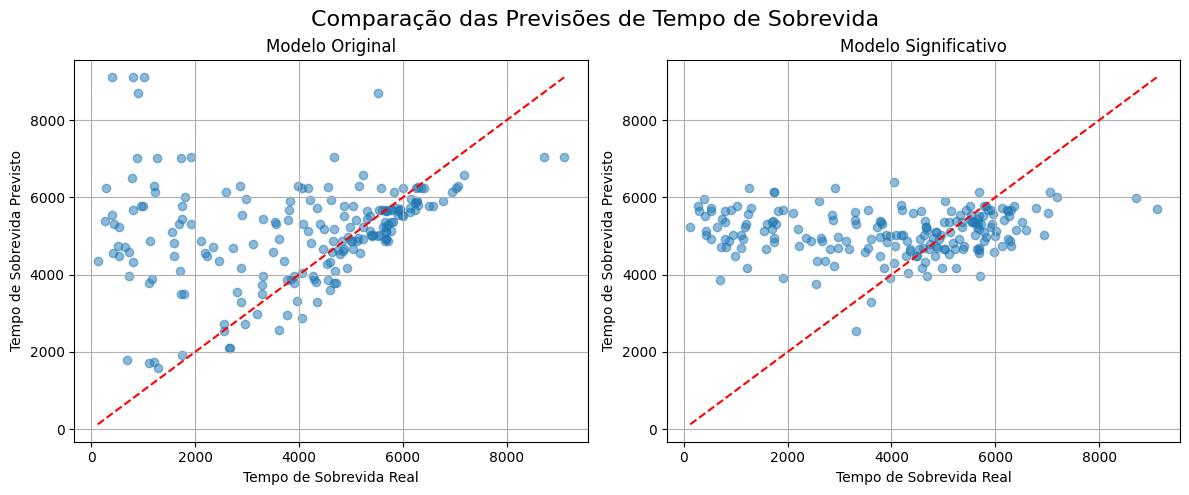

In [ ]:
# Gráfico de comparação
plt.figure(figsize=(12, 5))

# Gráfico para o modelo original
plt.subplot(1, 2, 1)
plt.scatter(df_ns['Tempo em dias (Real)'], df_ns['Tempo em dias (Previsto)'], alpha=0.5)
plt.plot([df_ns['Tempo em dias (Real)'].min(), df_ns['Tempo em dias (Real)'].max()],
         [df_ns['Tempo em dias (Real)'].min(), df_ns['Tempo em dias (Real)'].max()],
         'r--')
plt.xlabel('Tempo de Sobrevida Real')
plt.ylabel('Tempo de Sobrevida Previsto')
plt.title('Modelo Original')
plt.grid(True)

# Gráfico para o modelo com variáveis significativas
plt.subplot(1, 2, 2)
plt.scatter(df_s['Tempo em dias (Real)'], df_s['Tempo em dias (Previsto)'], alpha=0.5)
plt.plot([df_s['Tempo em dias (Real)'].min(), df_s['Tempo em dias (Real)'].max()],
         [df_s['Tempo em dias (Real)'].min(), df_s['Tempo em dias (Real)'].max()],
         'r--')
plt.xlabel('Tempo de Sobrevida Real')
plt.ylabel('Tempo de Sobrevida Previsto')
plt.title('Modelo Significativo')
plt.grid(True)

# Ajusta o layout e exibe a figura
plt.tight_layout()
plt.suptitle('Comparação das Previsões de Tempo de Sobrevida', fontsize=16)
plt.subplots_adjust(top=0.88)
plt.show()

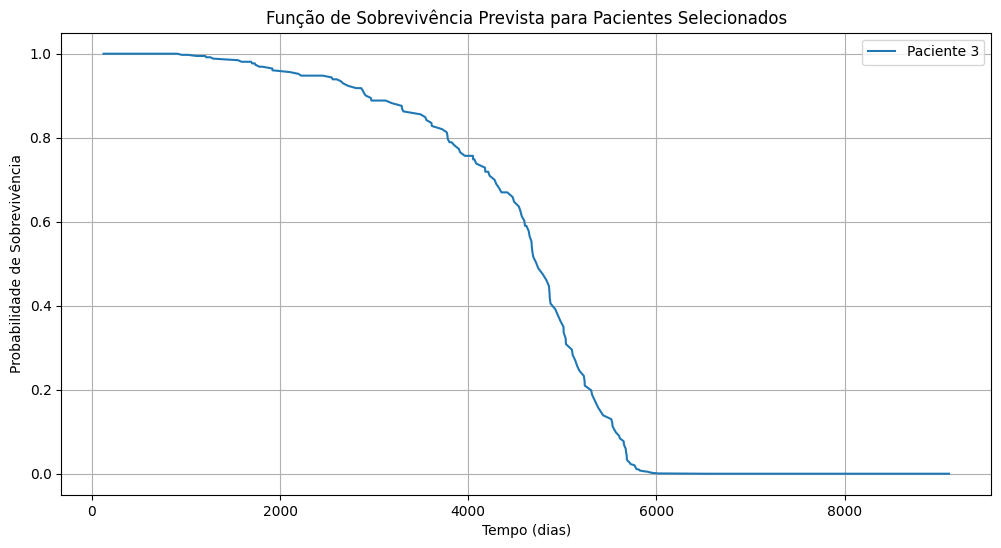

In [ ]:
from lifelines import CoxPHFitter

# Ajusta o modelo de Cox Proportional Hazards usando o DataFrame Xt
cph = CoxPHFitter()
cph.fit(Xt, duration_col='days', event_col='event')

# Realiza previsões da função de sobrevivência para todos os pacientes
survival_functions = cph.predict_survival_function(Xt)

# Lista de pacientes para exibir (índices começam em 0)
pacientes = [2]

# Visualiza a função de sobrevivência para os pacientes selecionados
plt.figure(figsize=(12, 6))
for i in pacientes:  # Itera sobre os pacientes selecionados
    plt.plot(survival_functions.index, survival_functions.iloc[:, i], label=f"Paciente {i+1}")

# Configurações do gráfico
plt.title("Função de Sobrevivência Prevista para Pacientes Selecionados")
plt.xlabel("Tempo (dias)")
plt.ylabel("Probabilidade de Sobrevivência")
plt.legend()
plt.grid(True)
plt.show()

#### <font color=	#FF34B3>**predict_expectation**

##### <font color=#FFE4C4>**Modelo Original**

In [ ]:
# Previsão da função de sobrevivência usando o modelo original
funcoes_sobrevivencia_original = cph.predict_survival_function(Xt)

# Exibir as previsões da função de sobrevivência para os primeiros pacientes
print("Previsões de tempo X Pacientes") # Coluna Vertical X Coluna Horizontal
display(funcoes_sobrevivencia_original)

Previsões de tempo X Pacientes


,0,1,2,3,4,5,6,7,8,9,...,188,189,190,191,192,193,194,195,196,197
125.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
269.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
289.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
394.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
404.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7023.0,3.541595e-17,1.138380e-02,1.844989e-12,0.155032,0.029119,1.206354e-02,2.311234e-03,2.060751e-05,0.135598,0.078700,...,4.122113e-143,2.160526e-21,5.999652e-60,4.110360e-09,0.124655,1.497316e-07,2.143610e-04,1.727017e-19,1.310279e-13,1.279098e-53
7057.0,1.186817e-21,3.369568e-03,1.186325e-15,0.093370,0.011128,3.627545e-03,4.433817e-04,1.094925e-06,0.078744,0.039416,...,7.668783e-182,5.167876e-27,4.667311e-76,2.151566e-11,0.070751,2.084092e-09,2.153641e-05,1.360243e-24,4.103293e-17,5.240201e-68
7185.0,1.186817e-21,3.369568e-03,1.186325e-15,0.093370,0.011128,3.627545e-03,4.433817e-04,1.094925e-06,0.078744,0.039416,...,7.668783e-182,5.167876e-27,4.667311e-76,2.151566e-11,0.070751,2.084092e-09,2.153641e-05,1.360243e-24,4.103293e-17,5.240201e-68
8711.0,1.308871e-34,9.922186e-05,6.790536e-25,0.021505,0.000687,1.118111e-04,3.718838e-06,2.230861e-10,0.016321,0.005322,...,5.434489e-294,2.729989e-43,1.054166e-122,5.338512e-18,0.013724,8.779039e-15,2.775858e-08,2.265467e-39,2.924917e-27,1.143029e-109


In [ ]:
from lifelines import CoxPHFitter

# Modelo original:
# Ajuste do modelo original
cph_original = CoxPHFitter()
cph_original_fitado = cph_original.fit(Xt, duration_col='days', event_col='event')

# Previsão do tempo de sobrevida para o modelo original
y_pred_tempo_original = cph_original_fitado.predict_expectation(Xt)

# Exibindo as previsões para o modelo original
df_pred_tempo_original = pd.DataFrame({'Tempo de Sobrevida (Real)': Xt['days'], 'Tempo de Sobrevida (Previsto)': y_pred_tempo_original})
display(df_pred_tempo_original)

,Tempo de Sobrevida (Real),Tempo de Sobrevida (Previsto)
0,723.0,4110.711668
1,6591.0,5511.438501
2,524.0,4365.868999
3,6255.0,6123.381980
4,3822.0,5657.070883
...,...,...
193,5673.0,4745.071175
194,404.0,5135.599383
195,2225.0,4007.890100
196,2722.0,4296.710552


##### <font color=#FFE4C4>**Valores Significativos**

In [ ]:
from lifelines import CoxPHFitter

# Ajustar o modelo com o conjunto de variáveis significativas
cph_significativo = CoxPHFitter()
cph_significativo_fitado = cph_significativo.fit(Xt_significativos, duration_col='days', event_col='event')

# Previsão da função de sobrevivência usando o modelo ajustado
funcoes_sobrevivencia_significativo = cph_significativo_fitado.predict_survival_function(Xt_significativos)

# Exibir as previsões da função de sobrevivência para os primeiros pacientes
print("Previsões de tempo X Pacientes") # Coluna Vertical X Coluna Horizontal
display(funcoes_sobrevivencia_significativo)

Previsões de tempo X Pacientes


,0,1,2,3,4,5,6,7,8,9,...,188,189,190,191,192,193,194,195,196,197
125.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
269.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
289.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
394.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
404.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7023.0,0.001998,0.015462,0.119063,0.043469,0.023651,0.030632,0.053844,0.006704,0.015099,0.054553,...,1.113896e-04,0.003779,0.035505,0.013636,0.057749,0.040002,0.042137,0.002116,1.340914e-04,0.026066
7057.0,0.000804,0.008395,0.087174,0.027459,0.013665,0.018383,0.035096,0.003221,0.008169,0.035626,...,2.935913e-05,0.001669,0.021773,0.007268,0.038030,0.024963,0.026497,0.000858,3.631618e-05,0.015277
7185.0,0.000804,0.008395,0.087174,0.027459,0.013665,0.018383,0.035096,0.003221,0.008169,0.035626,...,2.935913e-05,0.001669,0.021773,0.007268,0.038030,0.024963,0.026497,0.000858,3.631618e-05,0.015277
8711.0,0.000161,0.002856,0.050279,0.012205,0.005189,0.007464,0.016487,0.000883,0.002762,0.016793,...,2.789236e-06,0.000394,0.009184,0.002394,0.018192,0.010859,0.011683,0.000175,3.619708e-06,0.005949


In [ ]:
from lifelines import CoxPHFitter

# Ajuste do modelo com variáveis significativas (caso ainda não tenha feito)
cph_significativo = CoxPHFitter()
cph_significativo.fit(Xt_significativos, duration_col='days', event_col='event')

# Previsão do tempo de sobrevida para o modelo com variáveis significativas
y_pred_tempo_significativo = cph_significativo.predict_expectation(Xt_significativos)

# Exibindo as previsões para o modelo com variáveis significativas
df_pred_tempo_significativo = pd.DataFrame({
    'Tempo de Sobrevida (Real)': Xt_significativos['days'],
    'Tempo de Sobrevida (Previsto)': y_pred_tempo_significativo
})
display(df_pred_tempo_significativo)

,Tempo de Sobrevida (Real),Tempo de Sobrevida (Previsto)
0,723.0,4317.685799
1,6591.0,4734.148520
2,524.0,5511.173442
3,6255.0,5044.892756
4,3822.0,4849.135129
...,...,...
193,5673.0,5015.447150
194,404.0,5033.758333
195,2225.0,4327.334820
196,2722.0,3939.659862


##### <font color=#FFE4C4>**Comparação**

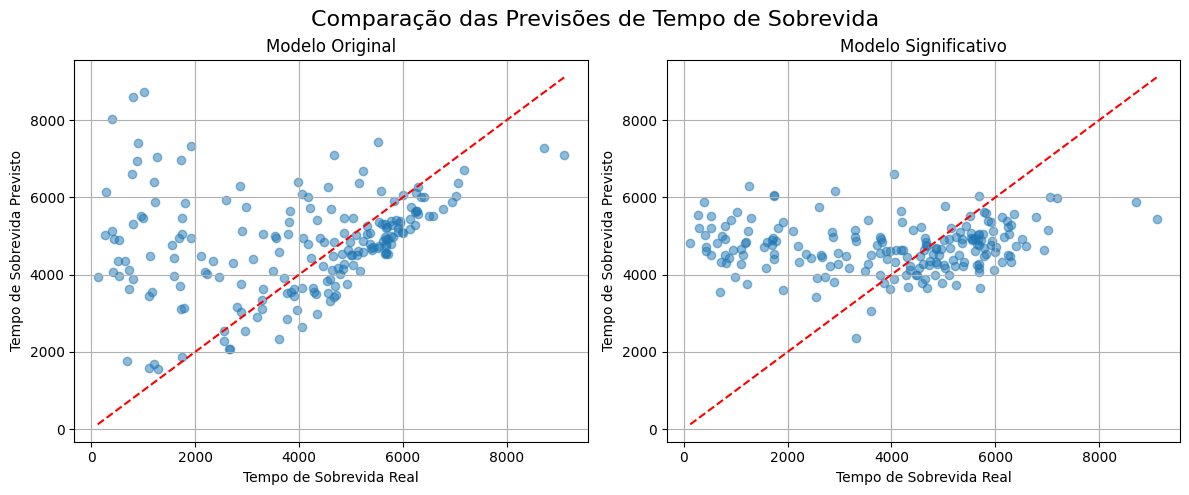

In [ ]:
# Ajustando os DataFrames para ter os nomes corretos das colunas
df_pred_tempo_original.columns = ['Tempo de Sobrevida Real', 'Tempo de Sobrevida Previsto (Original)']
df_pred_tempo_significativo.columns = ['Tempo de Sobrevida Real', 'Tempo de Sobrevida Previsto (Significativo)']

# Configura a figura para visualização
plt.figure(figsize=(12, 5))

# Gráfico para o modelo original
plt.subplot(1, 2, 1)
plt.scatter(df_pred_tempo_original['Tempo de Sobrevida Real'], df_pred_tempo_original['Tempo de Sobrevida Previsto (Original)'], alpha=0.5)
plt.plot([df_pred_tempo_original['Tempo de Sobrevida Real'].min(), df_pred_tempo_original['Tempo de Sobrevida Real'].max()],
         [df_pred_tempo_original['Tempo de Sobrevida Real'].min(), df_pred_tempo_original['Tempo de Sobrevida Real'].max()],
         'r--')
plt.xlabel('Tempo de Sobrevida Real')
plt.ylabel('Tempo de Sobrevida Previsto')
plt.title('Modelo Original')
plt.grid(True)

# Gráfico para o modelo com variáveis significativas
plt.subplot(1, 2, 2)
plt.scatter(df_pred_tempo_significativo['Tempo de Sobrevida Real'], df_pred_tempo_significativo['Tempo de Sobrevida Previsto (Significativo)'], alpha=0.5)
plt.plot([df_pred_tempo_significativo['Tempo de Sobrevida Real'].min(), df_pred_tempo_significativo['Tempo de Sobrevida Real'].max()],
         [df_pred_tempo_significativo['Tempo de Sobrevida Real'].min(), df_pred_tempo_significativo['Tempo de Sobrevida Real'].max()],
         'r--')
plt.xlabel('Tempo de Sobrevida Real')
plt.ylabel('Tempo de Sobrevida Previsto')
plt.title('Modelo Significativo')
plt.grid(True)

# Ajusta o layout e exibe a figura
plt.tight_layout()
plt.suptitle('Comparação das Previsões de Tempo de Sobrevida', fontsize=16)
plt.subplots_adjust(top=0.88)
plt.show()

### <font color=#FFB90F>**Kaplan-Meier**


#### <font color = #63B8FF>**Explicação**

---

<font color=00BFFF00BFFF#00FF7F>Aqui foi usado o estimador de Kaplan-Meier, que é uma ferramenta não paramétrica usada para estimar a função de sobrevivência a partir de dados censurados. No caso, ele foi usado para a fazer a plotagem da curva de sobrevivência usando como parâmetros os dias e o evento.

---

* <font color=#FF0000#DAA520>**KaplanMeierFitter():**</font> Cria o estimador.
* <font color=#FF0000#DAA520>**fit():**</font> Ajusta o modelo aos dados de sobrevivência.
* <font color=#FF0000#DAA520>**plot_survival_function():**</font> Plota a curva de sobrevivência.

---

#### <font color = #AB82FF>**Curva de Sobrevivência de Kaplan-Meier**

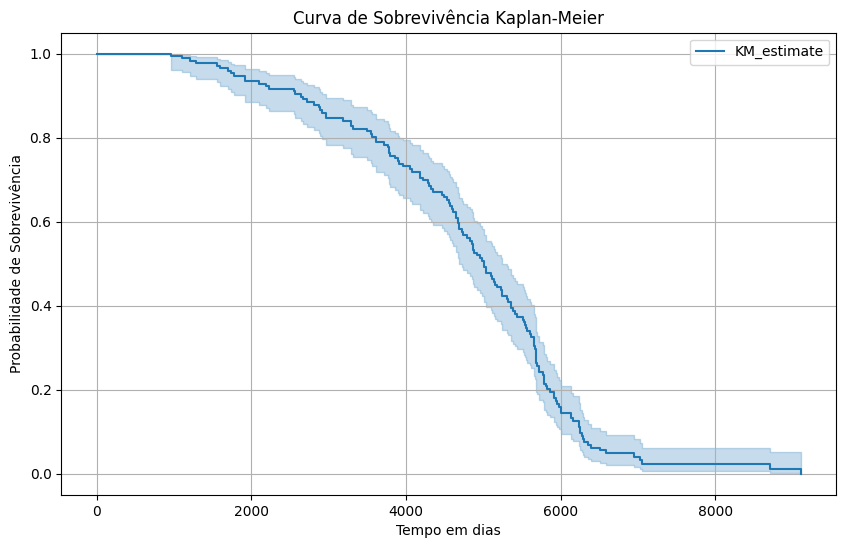

In [ ]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter() # Cria uma instância do estimador Kaplan-Meier
kmf.fit(Xt['days'], Xt['event']) # Ajusta o modelo Kaplan-Meier aos dados de duração e evento

# Configura a figura para o gráfico da curva de sobrevivência
plt.figure(figsize=(10,6))

# Cria um gráfico da curva de sobrevivência de Kaplan-Meier
kmf.plot_survival_function()
plt.title('Curva de Sobrevivência Kaplan-Meier')
plt.xlabel('Tempo em dias')
plt.ylabel('Probabilidade de Sobrevivência')
plt.grid(True)
plt.show()

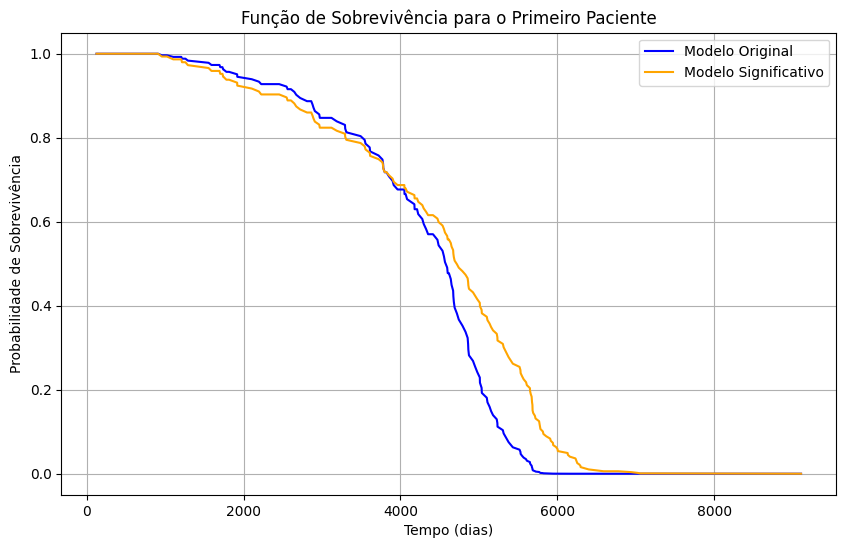

In [ ]:
from lifelines import CoxPHFitter

# Ajuste do modelo com o conjunto de dados original
cph_original = CoxPHFitter()
cph_original.fit(Xt, duration_col='days', event_col='event')

# Previsão da função de sobrevivência usando o modelo original
funcoes_sobrevivencia_original = cph_original.predict_survival_function(Xt)

# Ajuste do modelo com as variáveis significativas
cph_significativo = CoxPHFitter()
cph_significativo.fit(Xt_significativos, duration_col='days', event_col='event')

# Previsão da função de sobrevivência usando o modelo com variáveis significativas
funcoes_sobrevivencia_significativo = cph_significativo.predict_survival_function(Xt_significativos)




# Visualização das funções de sobrevivência para um paciente específico (por exemplo, o primeiro paciente)
plt.figure(figsize=(10, 6))

# Função de sobrevivência para o primeiro paciente do modelo original
plt.plot(funcoes_sobrevivencia_original.index, funcoes_sobrevivencia_original.iloc[:, 0], label="Modelo Original", color="blue")

# Função de sobrevivência para o primeiro paciente do modelo com variáveis significativas
plt.plot(funcoes_sobrevivencia_significativo.index, funcoes_sobrevivencia_significativo.iloc[:, 0], label="Modelo Significativo", color="orange")

plt.title("Função de Sobrevivência para o Primeiro Paciente")
plt.xlabel("Tempo (dias)")
plt.ylabel("Probabilidade de Sobrevivência")
plt.legend()
plt.grid(True)
plt.show()

### <font color=#FFB90F>**Hazard Ratios**

#### <font color = #63B8FF>**Explicação**

---

<font color=00BFFF00BFFF#00FF7F>Esta seção calcula as hazard ratios, que indicam o risco relativo de falha (evento) para diferentes grupos ou indivíduos com base em suas características. Eles são utilizados nos modelos de risco proporcional de Cox, onde ajudam a entender o efeito de variáveis preditoras (covariáveis) sobre o tempo até a ocorrência do evento.

---

* <font color=#FF0000#DAA520>**predict_partial_hazard():**</font> Gera os chances (scores) de risco para cada indivíduo contido no banco de dados.

---

<font color=00BFFF00BFFF#00FF7F>O hazard ratio é uma medida do quão frequentemente um evento ocorre em um grupo em comparação com outro grupo, durante um determinado período de tempo. E após ele ser calculado a partir do modelo de Cox, o mesmo pode ter as seguintes interpretações:

<font color=#FF0000#DAA520>**HR = 1:**</font>

* Indica que não há diferença no risco de ocorrência do evento entre os grupos comparados. Ou seja, a variável em questão não afeta o risco de falha.


<font color=#FF0000#DAA520>**HR > 1:**</font>

* Indica que o grupo de interesse tem um risco maior de ocorrência do evento em comparação ao grupo de referência. Por exemplo, um HR de 1,5 sugere que o grupo de interesse tem um risco 50% maior de falha (evento ocorrer) do que o grupo de referência.

<font color=#FF0000#DAA520>**HR < 1:**</font>

* Indica que o grupo de interesse tem um risco menor de ocorrência do evento em comparação ao grupo de referência. Por exemplo, um HR de 0,7 sugere que o grupo de interesse tem um risco 30% menor de falha (evento ocorrer) do que o grupo de referência.

<center><font size="5" color=#EEDD82>$HR = e^{β}$</center><font>

<font color=#FF0000#DAA520>$HR$</font> = Hazard Ratio

<font color=#FF0000#DAA520>$β$</font> = Coeficiente estimado para a covariável no modelo de Cox.

---

#### <font color = #C0FF3E>**Código**

In [ ]:
# Calcula as previsões de risco (hazard ratios) para os dados
risk_scores = cph.predict_partial_hazard(Xt)
print("Previsões de risco para os dados:")
display(risk_scores)

Previsões de risco para os dados:


,0
0,2.773091
1,0.327649
2,1.977987
3,0.136470
4,0.258891
...,...
193,1.150429
194,0.618454
195,3.162805
196,2.171610


In [ ]:
# Extrai os tempos de sobrevivência (em dias) da variável de resposta y
time_days = [tup[-1] for tup in y]

# Cria um DataFrame com as previsões de risco e os tempos de sobrevivência
df_h = pd.DataFrame({'Tempo em dias': time_days, 'Previsões de risco': risk_scores})
display(df_h)

,Tempo em dias,Previsões de risco
0,723.0,2.773091
1,6591.0,0.327649
2,524.0,1.977987
3,6255.0,0.136470
4,3822.0,0.258891
...,...,...
193,5673.0,1.150429
194,404.0,0.618454
195,2225.0,3.162805
196,2722.0,2.171610


In [ ]:
# Maior previsão de risco
max_risk = risk_scores.max()
print(f"Maior previsão de risco: {max_risk}")

Maior previsão de risco: 70.84221107012726


#### <font color=#AB82FF>**Gráfico de Dispersão e Histograma**

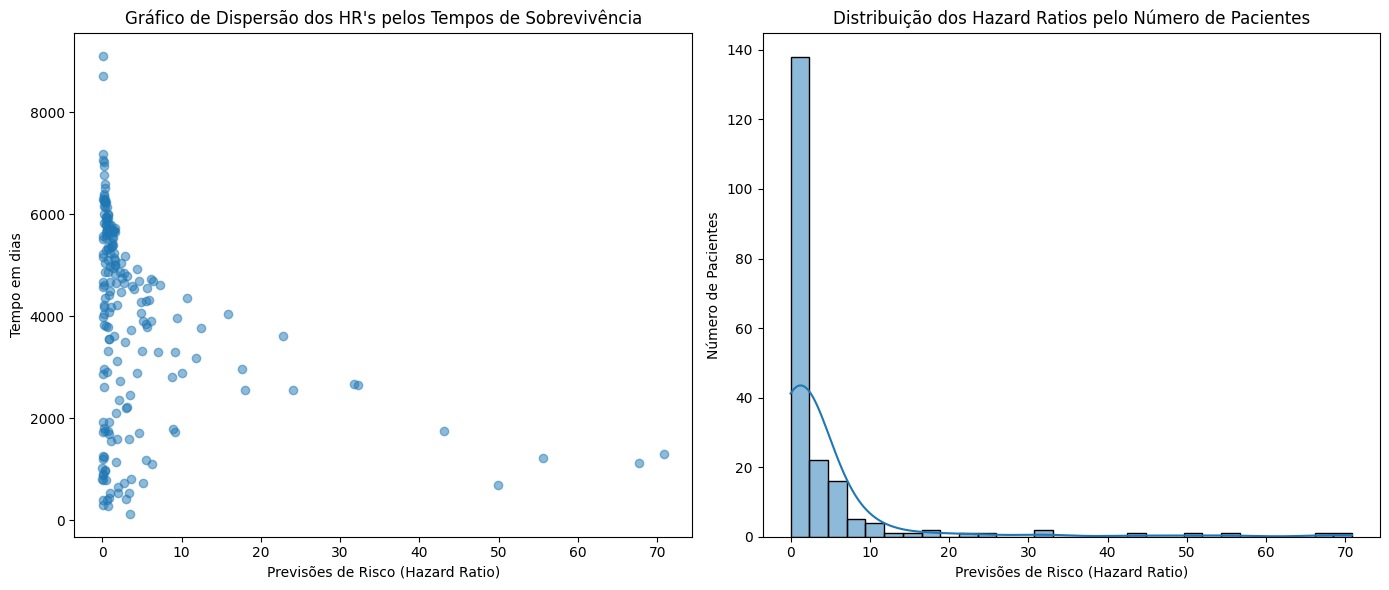

In [ ]:
# Verificar a distribuição dos HRs e tempos de sobrevivência
plt.figure(figsize=(14, 6))

# Gráfico de dispersão para verificar a relação entre HRs e tempos de sobrevivência
plt.subplot(1, 2, 1)
plt.scatter(df_h['Previsões de risco'], df_h['Tempo em dias'], alpha=0.5)
plt.xlabel('Previsões de Risco (Hazard Ratio)')
plt.ylabel('Tempo em dias')
plt.title("Gráfico de Dispersão dos HR's pelos Tempos de Sobrevivência")

# Histograma para ver a distribuição dos HRs
plt.subplot(1, 2, 2)
sns.histplot(df_h['Previsões de risco'], bins=30, kde=True)
plt.xlabel('Previsões de Risco (Hazard Ratio)')
plt.ylabel('Número de Pacientes')
plt.title('Distribuição dos Hazard Ratios pelo Número de Pacientes')

plt.tight_layout()
plt.show()

#### <font color=#FF34B3>**Boxplots para os Diferentes Grupos de Risco**

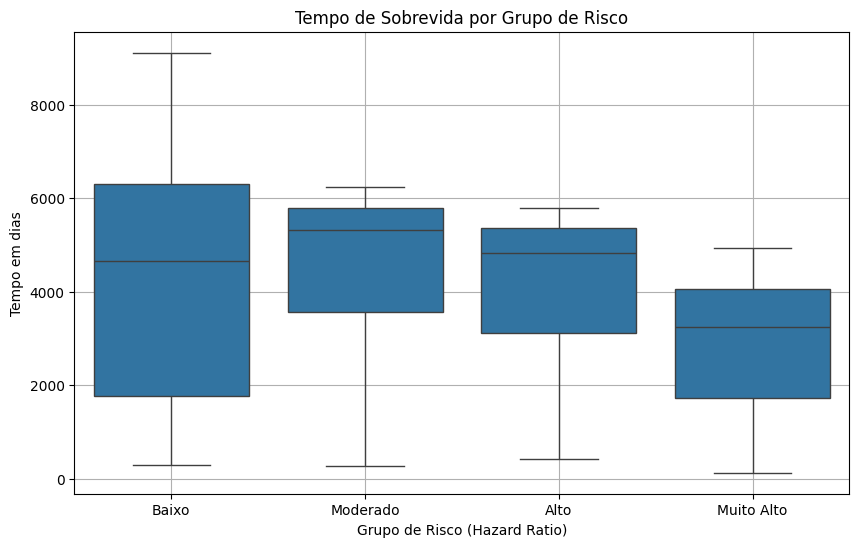

In [ ]:
# Adiciona uma nova coluna ao DataFrame 'df_h' categorizando os pacientes em quartis com base no Hazard Ratio
# A função pd.qcut() cria categorias de tamanhos iguais (quartis) para os hazard ratios
df_h['Grupo de Risco'] = pd.qcut(df_h['Previsões de risco'], q=4, labels=['Baixo', 'Moderado', 'Alto', 'Muito Alto'])

# Configura a figura para o gráfico de boxplot
plt.figure(figsize=(10, 6))

# Cria um gráfico de boxplot que mostra a distribuição do tempo de sobrevida para cada grupo de risco
# x='Grupo de Risco' especifica a variável categórica no eixo x
# y='Tempo em dias' especifica a variável numérica no eixo y
# data=df_h especifica o DataFrame usado para plotagem
sns.boxplot(x='Grupo de Risco', y='Tempo em dias', data=df_h)

# Define o rótulo do eixo x
plt.xlabel('Grupo de Risco (Hazard Ratio)')

# Define o rótulo do eixo y
plt.ylabel('Tempo em dias')

# Define o título do gráfico
plt.title('Tempo de Sobrevida por Grupo de Risco')

# Adiciona uma grade para facilitar a leitura do gráfico
plt.grid(True)

# Exibe o gráfico gerado
plt.show()


#### <font color=#AB82FF>**Gráfico de Dispersão e Histograma**

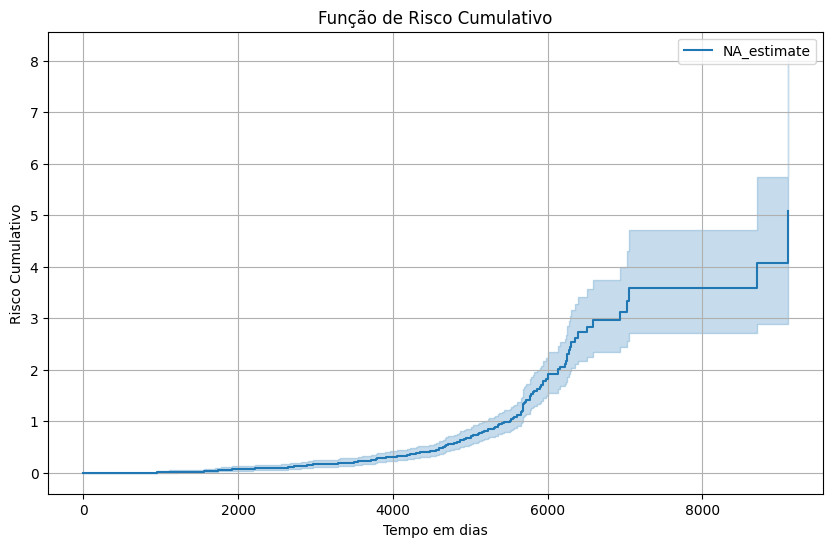

In [ ]:
from lifelines import NelsonAalenFitter

# Estima a função de risco cumulativo usando o Nelson-Aalen Fitter
# NelsonAalenFitter é um estimador não paramétrico para a função de risco cumulativo
naf = NelsonAalenFitter()

# Ajusta o modelo aos dados de sobrevivência
# Xt['days'] é o tempo de sobrevivência, e Xt['event'] é a variável indicadora de evento (1 se o evento ocorreu, 0 se não ocorreu)
naf.fit(Xt['days'], event_observed=Xt['event'])

# Visualização da função de risco cumulativo
# Plota a função de risco cumulativo estimada
plt.figure(figsize=(10, 6))
naf.plot()

# Define o título do gráfico
plt.title('Função de Risco Cumulativo')

# Define o rótulo do eixo x (Tempo em dias)
plt.xlabel('Tempo em dias')

# Define o rótulo do eixo y (Risco Cumulativo)
plt.ylabel('Risco Cumulativo')

# Adiciona uma grade ao gráfico
plt.grid(True)

# Exibe o gráfico gerado
plt.show()